# Set up notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging

# Configure logging for ActivationDataset to show info level messages
logger = logging.getLogger("ActivationDataset")
logger.setLevel(logging.INFO)

# Create a console handler if one doesn't exist
if not logger.handlers:
    console_handler = logging.StreamHandler()
    console_handler.setLevel(logging.INFO)
    formatter = logging.Formatter("%(name)s - %(levelname)s - %(message)s")
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Llama-8B")
model = AutoModelForCausalLM.from_pretrained(
    "deepseek-ai/DeepSeek-R1-Distill-Llama-8B",
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_8bit=True,
    ),
)
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear8bitLt(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): Lla

# Initialize the dataset and perform preprocessing

In [4]:
import os

import pyarrow.compute as pyarrow_compute

from backtracking.dataset.open_math import OpenMathDataset
from backtracking.dataset.storage import StorageType, set_cache_dirs

# Change these to relevant paths for your setup (or if you want, set the corresponding env vars).
# The main one is the PERSISTENT_CACHE_DIR; ideally this is a location that will persist between
# instances of your notebook, eg a RunPod Network Volume.
set_cache_dirs(
    {
        StorageType.persistent: os.getenv("PERSISTENT_CACHE_DIR", "/workspace"),
        StorageType.temporary: os.getenv("TEMPORARY_CACHE_DIR", "/tmp/spar_data"),
        StorageType.ephemeral: os.getenv("EPHEMERAL_CACHE_DIR", "/tmp/spar_temp"),
    }
)

# This will initialize a dataset from the Huggingface Hub with the given name and revision ID.
# The line after this will perform some pre-processing and save it to local directories as a
# collection of PyArrow datasets (backed by Parquet files).
dataset = OpenMathDataset(
    "open-r1/OpenR1-Math-220k",
    "e4e141ec9dea9f8326f4d347be56105859b2bd68",
    model,
    tokenizer,
)

# This will load any stages that have already been processed from persistent cache, and run any stages
# that can't be found. Options can be tweaked per the comments.
dataset.run_pipeline(
    ## Prevent any computation from being run at all, useful if you're paranoid about accidentally wiping
    ## out a previous run.
    # reprocess_on_load_failure=True,
    #################################
    ## Force a re-run of the listed stages
    # reprocess_stages=["raw", "token", "match"],
    #############################
    ## Only run on the first n rows of each stage
    process_head = 10_000,
    #####################
)

# Pre-processed data is available as dataset.raw, dataset.token, and dataset.match. PyArrow dataset operations
# can be performed with memory-mapping to avoid loading the entire thing in memory. You can load a subset of
# the dataset into memory as a list of dicts with a convenience __getitem__ wrapper, as in the below.
dataset.match.filter(
    pyarrow_compute.field("match_type") == "backtracking_candidate",
)[:3]

ActivationDataset.open-r1/OpenR1-Math-220k - INFO - Running pipeline stage: raw


Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Running pipeline stage raw:   0%|          | 0/10000 [00:00<?, ?it/s]

Adding row IDs to raw data:   0%|          | 0/10000 [00:00<?, ?it/s]

ActivationDataset.open-r1/OpenR1-Math-220k - INFO - Running pipeline stage: token


Running pipeline stage token:   0%|          | 0/10000 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (16607 > 16384). Running this sequence through the model will result in indexing errors


Adding row IDs to token data:   0%|          | 0/9978 [00:00<?, ?it/s]

ActivationDataset.open-r1/OpenR1-Math-220k - INFO - Running pipeline stage: match


Running pipeline stage match:   0%|          | 0/9978 [00:00<?, ?it/s]

Adding row IDs to match data:   0%|          | 0/270239 [00:00<?, ?it/s]

[{'raw_row_id': 1000,
  'token_row_id': 0,
  'match_type': 'backtracking_candidate',
  'context': 'erge of slipping.\n\nWait, but the option',
  'prefix_text': '.\n\n',
  'prefix_token_range': [307, 308],
  'match_text': 'Wait',
  'match_token_range': [308, 309],
  'suffix_text': '',
  'suffix_token_range': [309, 309],
  'match_row_id': 10},
 {'raw_row_id': 1000,
  'token_row_id': 0,
  'match_type': 'backtracking_candidate',
  'context': 'n a flat surface?\n\nWait, but the proble',
  'prefix_text': '?\n\n',
  'prefix_token_range': [528, 529],
  'match_text': 'Wait',
  'match_token_range': [529, 530],
  'suffix_text': '',
  'suffix_token_range': [530, 530],
  'match_row_id': 11},
 {'raw_row_id': 1000,
  'token_row_id': 0,
  'match_type': 'backtracking_candidate',
  'context': 'ed based on that.\n\nWait, perhaps the bo',
  'prefix_text': '.\n\n',
  'prefix_token_range': [1015, 1016],
  'match_text': 'Wait',
  'match_token_range': [1016, 1017],
  'suffix_text': '',
  'suffix_token_range':

# Run the model to collect activation data, or load this data from cache if already present

In [6]:
import pyarrow.compute as pyarrow_compute

from backtracking.dataset.open_math.activation_transform import Activation
from backtracking.dataset.storage import StorageType, load_dataset

# Get a sample of each backtracking cue
MIN_SAMPLE_SIZE = 100
target_class_names = (
    " Wait",
    "Wait",
    " No",
    "No",
    " Actually",
    "Actually",
)


def select_examples_to_run():
    from collections import defaultdict

    sample = defaultdict(list)
    for name in target_class_names:
        if len(sample[name]) >= MIN_SAMPLE_SIZE:
            continue
        for batch in dataset.match.scanner(
            columns=["token_row_id"],
            filter=(pyarrow_compute.field("match_type") == "backtracking_candidate")
            & (pyarrow_compute.field("match_text") == name),
        ).to_batches():
            sample[name].extend(
                batch["token_row_id"].to_pylist()[
                    0 : MIN_SAMPLE_SIZE - len(sample[name])
                ]
            )
            if len(sample[name]) >= MIN_SAMPLE_SIZE:
                break

    return sorted(list(set(sum((sample[name] for name in target_class_names), []))))


# Load the activations dataset if we've already processed it, otherwise process and save it.
# This takes about 20 minutes on a RunPod A40 instance with the sample set selected above. It will
# use about 6GB of space.
try:
    dataset.datasets["activation"] = load_dataset(
        StorageType.persistent, "demo_activations"
    )
except Exception:
    # Adding activations is still a bit manual at this point
    transform = Activation(
        model,
        tokenizer,
        dataset.match,
        storage_type=StorageType.persistent,
    )
    transform.run(
        dataset.token.take_dataset(select_examples_to_run()),
        "demo_activations",
        run_id=1,
    )
    dataset.datasets["activation"] = load_dataset(
        StorageType.persistent, "demo_activations"
    )


Writing dataset to persistent cache:   0%|          | 0/267 [00:00<?, ?it/s]

# Gather a sample for plots and steering

In [7]:
import re
from collections import defaultdict

from backtracking.ops import token_probs

baseline_activations = []
backtracking_activations = defaultdict(list)

MAX_SAMPLE_SIZE = 1_000


def include_target(name, act):
    probs = token_probs(target_class_names, act, model, tokenizer)
    if name == "Baseline":
        return sum(p[0] for p in probs.values()) < 0.05
    # Simple threshold
    return probs[name][0] >= 0.5


for batch in dataset.activation.batched_join(
    dataset.match,
    "match_row_id",
    self_projection=[re.compile(r"match_activations")],
    other_projection=["match_text", "match_type", "context"],
    other_filter=pyarrow_compute.field("match_type") == "sentence_start",
    limit=MAX_SAMPLE_SIZE - len(baseline_activations),
    progress_desc="Selecting baseline activations",
):
    baseline_activations.extend(
        b
        for b in batch.to_pylist()
        if include_target("Baseline", b["match_activations.31"])
    )

for name in target_class_names:
    for batch in dataset.activation.batched_join(
        dataset.match,
        "match_row_id",
        self_projection=[re.compile(r"match_activations")],
        other_projection=["match_text", "match_type", "context"],
        other_filter=(
            (pyarrow_compute.field("match_type") == "backtracking_candidate")
            & (pyarrow_compute.field("match_text") == name)
        ),
        limit=MAX_SAMPLE_SIZE - len(backtracking_activations[name]),
        progress_desc=f'Selecting "{name}" activations',
    ):
        backtracking_activations[name].extend(
            b
            for b in batch.to_pylist()
            if include_target(name, b["match_activations.31"])
        )


Selecting baseline activations:   0%|          | 0/12162 [00:00<?, ?it/s]

Selecting " Wait" activations:   0%|          | 0/12162 [00:00<?, ?it/s]

Selecting "Wait" activations:   0%|          | 0/12162 [00:00<?, ?it/s]

Selecting " No" activations:   0%|          | 0/12162 [00:00<?, ?it/s]

Selecting "No" activations:   0%|          | 0/12162 [00:00<?, ?it/s]

Selecting " Actually" activations:   0%|          | 0/12162 [00:00<?, ?it/s]

Selecting "Actually" activations:   0%|          | 0/12162 [00:00<?, ?it/s]

In [8]:
print(
    "Total baseline activations: ",
    len(baseline_activations),
)
print(
    "Total backtracking activations: ",
    sum(len(v) for k, v in backtracking_activations.items()),
)
print(
    "Backtracking activations by text: ",
    {k: len(v) for k, v in backtracking_activations.items()},
)

Total baseline activations:  930
Total backtracking activations:  1250
Backtracking activations by text:  {' Wait': 299, 'Wait': 675, ' No': 224, 'No': 41, ' Actually': 9, 'Actually': 2}


# Perform PCA on the collected sample

In [9]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

layers_to_run = range(len(model.model.layers))
pca_by_class = defaultdict(lambda: defaultdict(dict))
pca_transforms = {}
# Not big enough sample in demo for the other classes to get a nice plot, so don't use them for now
subset_class_names = ("Wait", " Wait")

# Balance classes
num_examples = min(
    len(t)
    for t in (
        baseline_activations,
        *tuple(backtracking_activations[n] for n in subset_class_names),
    )
)
print(
    f"Running PCA for classes {('Baseline',) + subset_class_names}\n    {num_examples} each"
    f"\n    layers {layers_to_run.start}--{layers_to_run.stop}"
)

for layer in layers_to_run:
    baseline = [
        a[f"match_activations.{layer}"][0, :]
        for a in baseline_activations[:num_examples]
    ]

    targets = tuple(
        [
            a[f"match_activations.{layer}"][0, :]
            for a in backtracking_activations[t][:num_examples]
        ]
        for t in subset_class_names
    )

    pca = PCA(n_components=2)
    pca_data = np.vstack((baseline, *targets))
    pca_result = pca.fit_transform(pca_data)
    pca_transforms[layer] = pca

    cur_offset = len(baseline)
    pca_by_class["Baseline"][layer] = pca_result[:cur_offset]
    for i, target_class in enumerate(subset_class_names):
        pca_by_class[target_class][layer] = pca_result[
            cur_offset : cur_offset + len(targets[i])
        ]
        cur_offset += len(targets[i])

Running PCA for classes ('Baseline', 'Wait', ' Wait')
    299 each
    layers 0--32


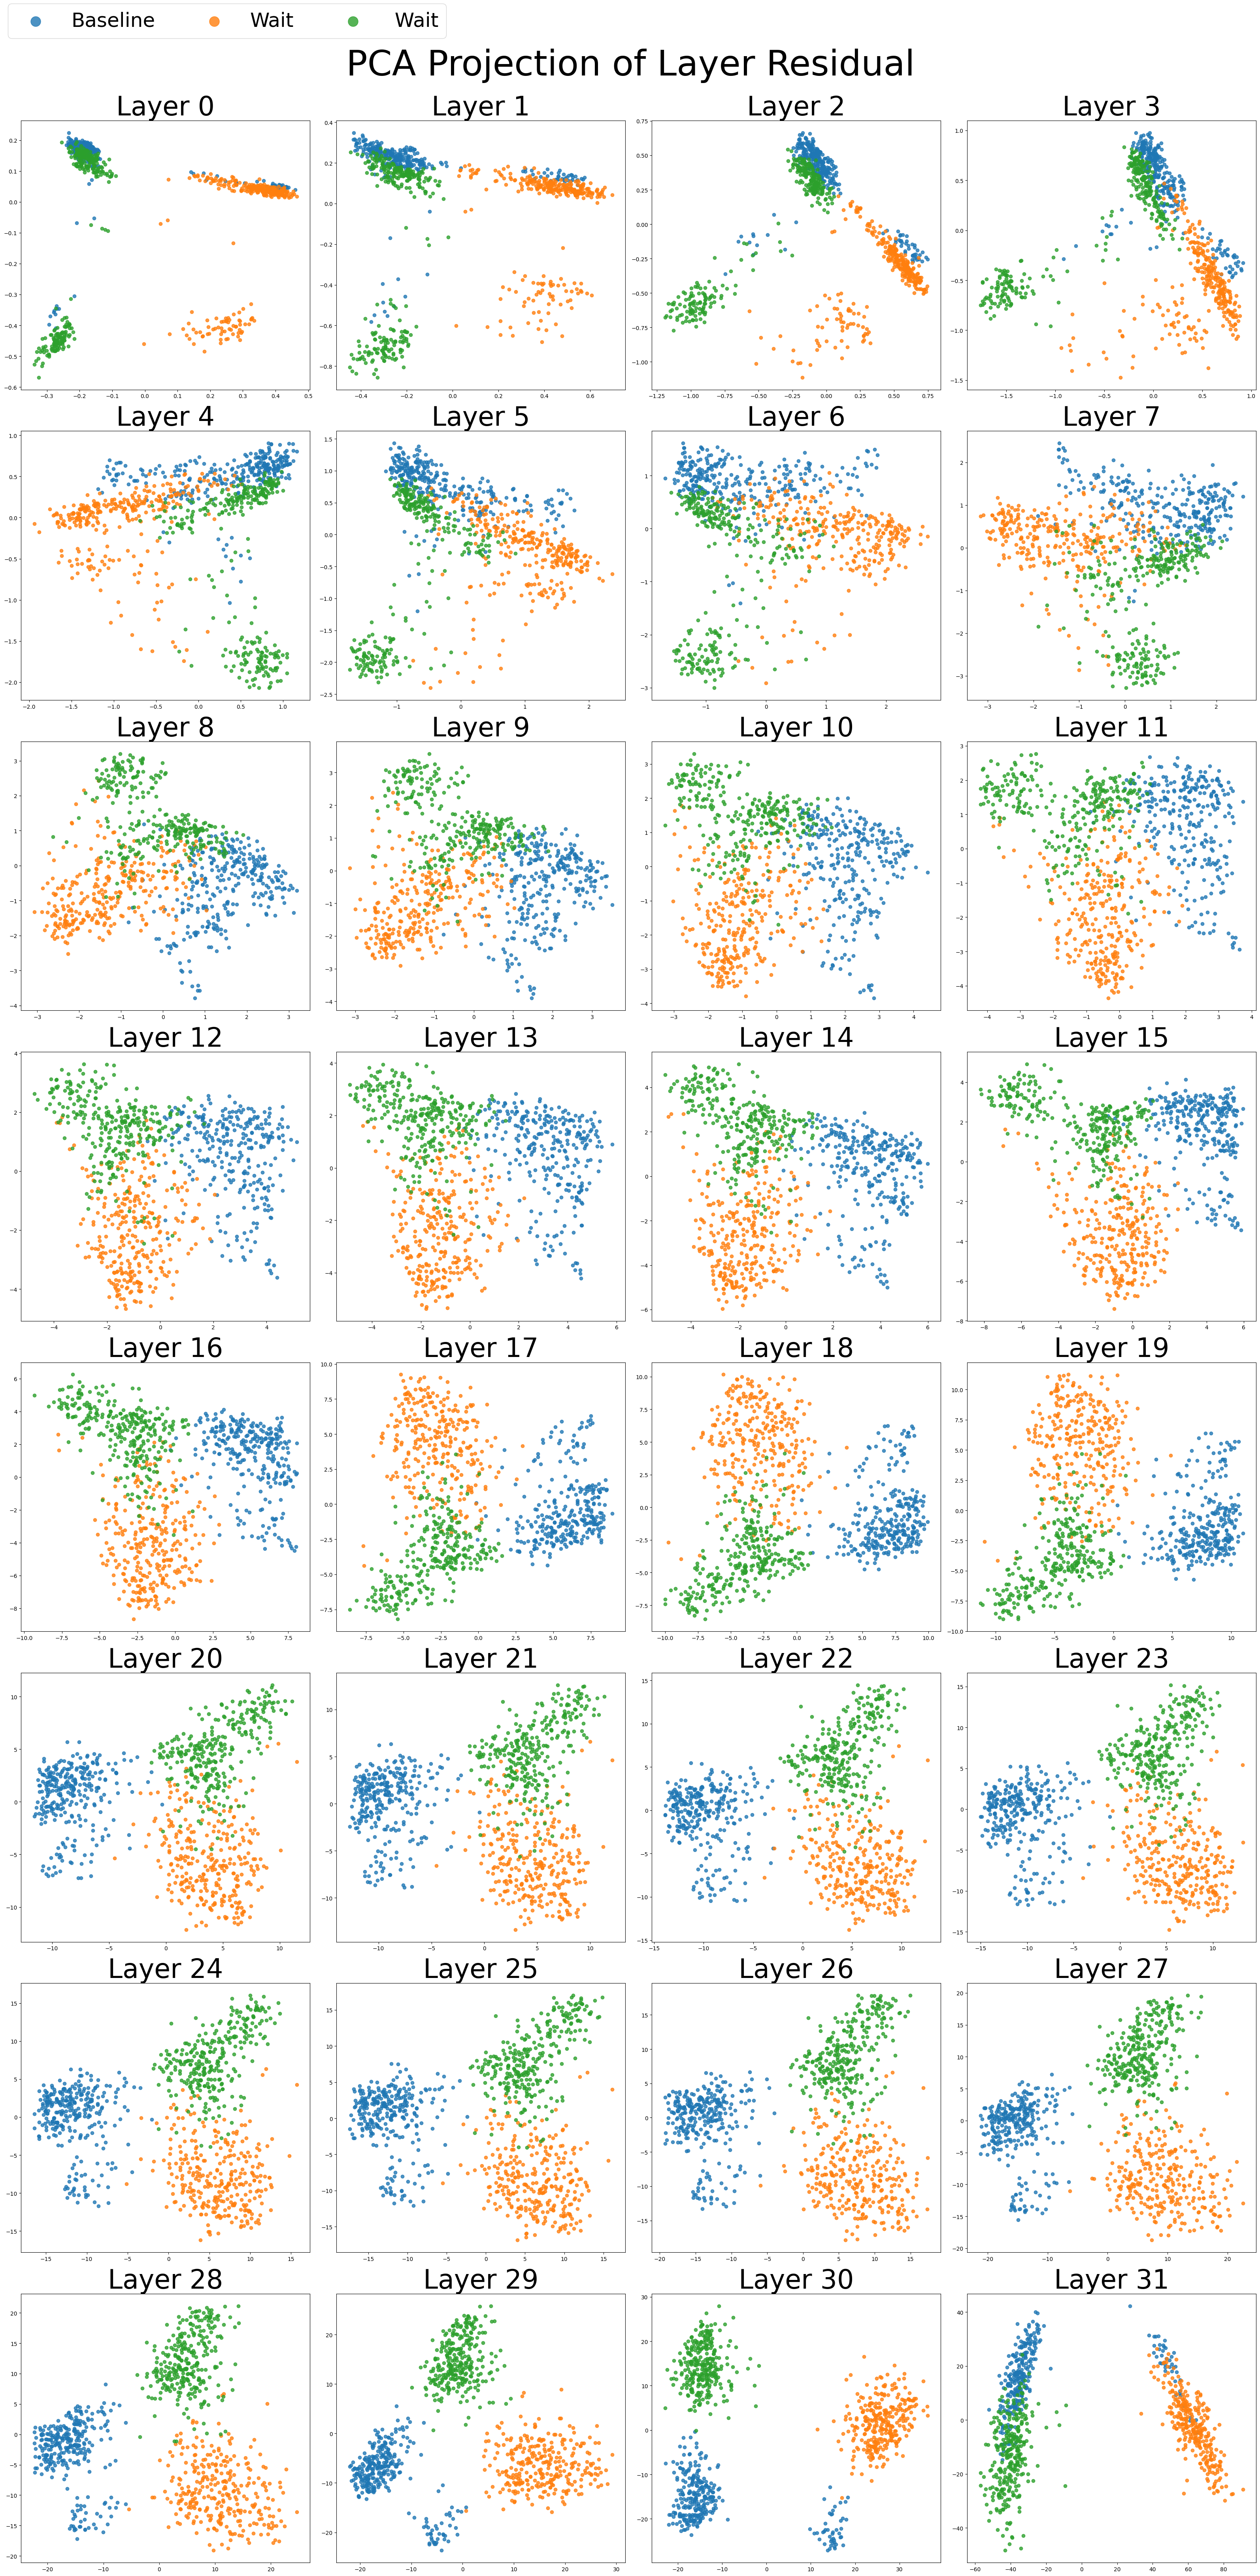

In [10]:
import matplotlib.pyplot as plt

layers_to_plot = range(layers_to_run.start, layers_to_run.stop)

num_layers = layers_to_plot.stop - layers_to_plot.start
num_rows = (num_layers + 3) // 4
fig, axes = plt.subplots(num_rows, 4, figsize=(32, 8 * num_rows))
axes = axes.flatten()

for layer in layers_to_plot:
    axis_index = layer - layers_to_plot.start
    for class_name, data in pca_by_class.items():
        axes[axis_index].scatter(
            data[layer][:, 0],
            data[layer][:, 1],
            label=class_name,
            alpha=0.8,
        )
    axes[axis_index].set_title(f"Layer {layer}", fontsize=48)

    if axis_index == 0:
        axes[axis_index].legend()

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower left",
    fontsize=36,
    bbox_to_anchor=(
        0,
        1.0,
    ),
    markerscale=3.0,
    ncol=4,
)
axes[0].get_legend().remove()
fig.suptitle("PCA Projection of Layer Residual", fontsize=64, y=1)
# Hide any unused subplots
for i in range(num_layers, len(axes)):
    axes[i].axis("off")

fig.tight_layout()

plt.show()

# Generate steering vectors

In [11]:
import numpy


def mean_vector(acts, layer):
    return numpy.mean(
        numpy.vstack(
            tuple(a[f"match_activations.{layer}"][0, :] for a in acts),
            dtype=numpy.float64,
        ),
        axis=0,
    )


def combo_mean(class_names, existing_means):
    renorm = sum(len(backtracking_activations[name]) for name in class_names)
    return {
        layer: numpy.sum(
            numpy.vstack(
                # renormalize since class sizes are unequal
                tuple(
                    existing_means[name][layer]
                    * len(backtracking_activations[name])
                    / renorm
                    for name in class_names
                ),
                dtype=numpy.float64,
            ),
            axis=0,
        )
        for layer in layers_to_run
    }


mean_class = {
    name: {
        layer: mean_vector(backtracking_activations[name], layer)
        for layer in layers_to_run
    }
    for name in backtracking_activations.keys()
    if len(backtracking_activations[name]) > 0
}
mean_class["Baseline"] = {
    layer: mean_vector(baseline_activations, layer) for layer in layers_to_run
}

mean_class["all"] = combo_mean(backtracking_activations.keys(), mean_class)
mean_class["waits"] = combo_mean(["Wait", " Wait"], mean_class)

steering_vectors = {
    name: {
        layer: mean_class[name][layer] - mean_class["Baseline"][layer]
        for layer in layers_to_run
    }
    for name in mean_class
    if name != "Baseline"
}

# Compare with SAEs

In [12]:
from sae_lens import SAE
from torch import no_grad, tensor

from backtracking.ops import compare_activation

# TODO: plot all pairwise, on all layers
sae = SAE.from_pretrained("llama_scope_r1_distill", "l15r_800m_slimpajama")[0].to("cuda")
baseline = tensor(mean_class["Baseline"][15]).to("cuda")

for name in ["all", "Baseline"]:
    with no_grad():
        if name == "Baseline":
            vector = baseline
        else:
            vector = tensor(steering_vectors[name][15]).to("cuda")

    compare_activation(name, vector, sae)

Cosine similarity between deepseek-r1-distill-llama-8b/15-llamascope-slimpj-res-32k and "all"
Most correlated SAE features
  SAE feature 13291, cosine sim: 0.3177615205077494
  SAE feature 13190, cosine sim: 0.31576192112830664
  SAE feature 9558, cosine sim: 0.20590107997994764
  SAE feature 822, cosine sim: 0.18458507739709967
  SAE feature 31723, cosine sim: 0.17693520771398713
  SAE feature 11549, cosine sim: 0.1737235182592694
  SAE feature 7116, cosine sim: 0.16879821617707932
  SAE feature 25343, cosine sim: 0.14122198934963573
  SAE feature 30482, cosine sim: 0.14108574462940998
  SAE feature 13703, cosine sim: 0.1360709463479517
Most anti-correlated SAE features
  SAE feature 8309, cosine sim: -0.32255761665074384
  SAE feature 24377, cosine sim: -0.24422372368078377
  SAE feature 8727, cosine sim: -0.2077795519499095
  SAE feature 4329, cosine sim: -0.20661467220221658
  SAE feature 30012, cosine sim: -0.20071522995795618
  SAE feature 4561, cosine sim: -0.19476305341086325
 

# Generate text with steering

In [13]:
from backtracking.ops import generate
from backtracking.steering import SteeringFlag, add_steering_vector

# Toggle on/off, directional ablation mode, or tweak scale
steering = SteeringFlag(on=True, directional_ablation=False, scale=8)
with add_steering_vector(
    19, torch.tensor(steering_vectors["all"][19]), model, steering=steering
):
    example = dataset.token[655]
    prompt = example["prefill"][: example["prompt_len"]]
    print(prompt)
    try:
        generate(prompt, model, tokenizer)
    except KeyboardInterrupt:
        print("\n\n*** Generation aborted by user ***")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Two circles touch in $M$, and lie inside a rectangle $ABCD$. One of them touches the sides $AB$ and $AD$, and the other one touches $AD,BC,CD$. The radius of the second circle is four times that of the first circle. Find the ratio in which the common tangent of the circles in $M$ divides $AB$ and $CD$.
Please reason step by step, and put your final answer within \boxed{}.

Okay, so I have this geometry problem here. Let me try to understand it step by step.

We have a rectangle ABCD. Inside this rectangle, there are two circles that touch at point M. One circle touches sides AB and AD. The other circle touches AD, BC, and CD. Additionally, it's given that the radius of the second circle is four times that of the first circle. The question is asking for the ratio in which the common tangent at M divides AB and CD.

Wait, hold on. Common tangent at M? Or is it the common tangent line passing through M? Because if they touch at M, then the tangent at M is common to both circles. So, yes, 